## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/)) <b><font size='3ptx'>[Generative Adversarial Networks](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/), or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.</font></b>

Developing a GAN for generating images requires both a discriminator convolutional neural network model for classifying whether a given image is real or generated and a generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. **A good starting point for beginners is to practice developing and using GANs on standard image datasets used in the field of computer vision, such as the [MNIST handwritten digit dataset](https://www.kaggle.com/code/ngbolin/mnist-dataset-digit-recognizer/data)**. Using small and well-understood datasets means that smaller models can be developed and trained quickly, allowing the focus to be put on the model architecture and image generation process itself.

**In this tutorial, you will discover how to develop a generative adversarial network with deep convolutional networks for generating handwritten digits.** After completing this tutorial, you will know:
* How to define and train the standalone discriminator model for learning the difference between real and fake images.
* How to define the standalone generator model and train the composite generator and discriminator model.
* How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into seven parts; they are:
* <font size='3ptx'><b><a href='#sect1'>MNIST Handwritten Digit Dataset</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>How to Define and Train the Discriminator Model</a></b></font>
* How to Define and Use the Generator Model
* How to Train the Generator Model
* How to Evaluate GAN Model Performance
* Complete Example of GAN for MNIST
* How to Use the Final Generator Model to Generate Images

In [4]:
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

<a id='sect1'></a>
## <font color='darkblue'>MNIST Handwritten Digit Dataset</font>
<font size='3ptx'><b>The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is an acronym that stands for the Modified National Institute of Standards and Technology dataset.</b></font>

It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9. The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

Keras provides access to the MNIST dataset via the [mnist.load_dataset()](https://keras.io/datasets/#mnist-database-of-handwritten-digits) function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

The example below loads the dataset and summarizes the shape of the loaded dataset.

<b><font color='darkred'>Note</font></b>: the first time you load the dataset, Keras will automatically download a compressed version of the images and save them under your home directory in <font color='olive'>~/.keras/datasets/</font>. The download is fast as the dataset is only about eleven megabytes in its compressed form.

In [2]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11490434/11490434 [==============================] - 3s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Running the example loads the dataset and prints the shape of the input and output components of the train and test splits of images.

<b>We can see that there are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels.</b>

The images are grayscale with a black background (<font color='brown'>0 pixel value</font>) and the handwritten digits in white (<font color='brown'>pixel values near 255</font>). This means if the images were plotted, they would be mostly black with a white digit in the middle.

We can plot some of the images from the training dataset using the matplotlib library using the [imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function and specify the color map via the ‘cmap‘ argument as ‘gray‘ to show the pixel values correctly.

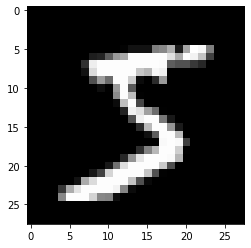

In [6]:
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray')

Alternately, the images are <b>easier to review when we reverse the colors and plot the background as white and the handwritten digits in black</b>. They are easier to view as most of the image is now white with the area of interest in black. This can be achieved using a reverse grayscale color map, as follows:

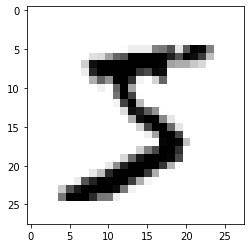

In [7]:
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray_r')

The example below plots the first 25 images from the training dataset in a 5 by 5 square:

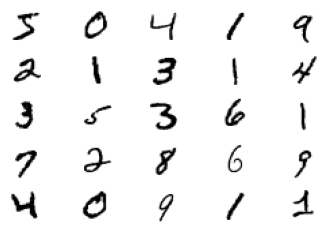

In [8]:
for i in range(25):
  # define subplot
  plt.subplot(5, 5, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(trainX[i], cmap='gray_r')
  
plt.show()

We will use the images in the training dataset as the basis for training a Generative Adversarial Network.

<b>Specifically, the <font color='darkblue'>generator</font> model will learn how to generate new plausible handwritten digits between 0 and 9, using a <font color='darkblue'>discriminator</font> that will try to distinguish between real images from the MNIST training dataset and new images output by the generator model</b>.

This is a relatively simple problem that does not require a sophisticated generator or discriminator model, although it does require the generation of a grayscale output image.

<a id='sect2'></a>
## <font color='darkblue'>How to Define and Train the Discriminator Model</font>
<font size='3ptx'><b>The first step is to define the discriminator model.</b></font>

<b>The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.</b> This is a binary classification problem:
* **Inputs**: Image with one channel and 28×28 pixels in size.
* **Outputs**: Binary classification, likelihood the sample is real (or fake).

**The discriminator model has two [convolutional layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) with 64 filters each, a small kernel size of 3, and larger than normal stride of 2.** The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the [binary cross entropy loss function](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/), appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the <b>use of LeakyReLU instead of [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), using [Dropout](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/), and using the [Adam version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with a learning rate of 0.0002 and a momentum of 0.5</b>.

## <font color='darkblue'>Supplement</font>
* [RealPython - Generative Adversarial Networks: Build Your First Models (PyTorch)](https://realpython.com/generative-adversarial-networks/)